# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [69]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

<ipython-input-69-8c32cb05a179>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


### Data Manipulation
Since the SEIFA dataset contains not only the LGA in South Australia, but also other states across Australia. Therefore, to avoid the duplication of the LGA which has the same name as LGA in South Australia, we have to only use the data related to South Australia to answer the questions. 

In [70]:
# Count the number of records in each LGA
seifa.groupby(["LGA"]).size()

LGA
ADELAIDE           16
ADELAIDE HILLS     16
ALBANY             16
ALBURY             16
ALEXANDRINA        16
                   ..
YASS VALLEY        16
YILGARN            16
YORK               16
YORKE PENINSULA    16
YOUNG              16
Length: 556, dtype: int64

* ***Comment:*** There should 16 records for each LGA, since there are also four types of socio-economic indexes, and each index has four measures (score, max, min, URP). Therefore, any LGA which has more than 16 records would be considered as duplicated results.

In [5]:
temp = seifa['LGA'].value_counts().rename_axis('LGA').reset_index(name='counts')
temp.head()

temp[temp.counts > 16]

,LGA,counts
0,KINGSTON,32
1,LATROBE,32
2,WELLINGTON,32
3,CENTRAL HIGHLANDS,32
4,FLINDERS,32
5,CAMPBELLTOWN,32
6,NARROGIN,32
7,MURRAY,32


* ***Comment:*** There are eight LGAs which are duplicated in the SEIFA dataset.

To only include LGA from South Australia (start with '4' in the LGA id `LGA_2011`), we update the SEIFA dataset to drop all other LGA from other states across Australia.

In [71]:
sa_seifa = seifa[seifa['LGA_2011'].astype(str).str[0] == '4']
sa_seifa

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
1228,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1036,ADELAIDE
1229,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,909,ADELAIDE
1230,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1141,ADELAIDE
1231,40070,Adelaide (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,19606,ADELAIDE
1232,40120,Adelaide Hills (DC),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,1077,ADELAIDE HILLS
...,...,...,...,...,...,...,...,...
8275,48830,Yorke Peninsula (DC),IEO,Index of Education and Occupation,URP,Usual resident population,11046,YORKE PENINSULA
8276,49399,Unincorporated SA,IEO,Index of Education and Occupation,SCORE,Score,911,UNINCORPORATED SA
8277,49399,Unincorporated SA,IEO,Index of Education and Occupation,MINS,Minimum score for SA1s in area,585,UNINCORPORATED SA
8278,49399,Unincorporated SA,IEO,Index of Education and Occupation,MAXS,Maximum score for SA1s in area,1121,UNINCORPORATED SA


In [77]:
# check again if there is still any duplicated LGA
temp = sa_seifa['LGA'].value_counts().rename_axis('LGA').reset_index(name='counts')
temp.head()

temp[temp.counts > 16]

,LGA,counts


* ***Comment:*** All the duplicated LGAs have been dropped.

Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [82]:
LGA_scores = sa_seifa[sa_seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = sa_seifa[sa_seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_pop.head()
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
ALEXANDRINA,1000,1000,969,987,23693
ANANGU PITJANTJATJARA,623,623,672,593,2433
BAROSSA,1028,1028,997,1017,22174


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [83]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


We check if there is any missing value in the dataset.

In [84]:
sa_vouchers_scores.isna().sum()

Participant_ID                   0
Participant_Suburb               0
Club_Previous_Member             0
Participant_ATSI_Indicator       0
Participant_CALD_Indicator       0
Participant_Sex                  0
Voucher_Value                    0
Club_Name                        0
Voucher_Sport                    0
Participant_LGA                  0
Participant_Electorate           0
Voucher_Completion_Date       2080
Voucher_Claim_Year               0
IEO                           9460
IER                           9460
IRSAD                         9460
IRSD                          9460
Population                    9460
dtype: int64

In [85]:
# check if there is NaN value in the LGA_scores (i.e. SEIFA pivot dataset)
LGA_scores.isna().sum()

INDEX_TYPE
IEO           0
IER           0
IRSAD         0
IRSD          0
Population    0
dtype: int64

In [86]:
# Check the LGAs which have no population records 
# (the same with IEO, IER, IRSAD, IRSD which come from the SEIFA dataset)
sa_vouchers_scores['Participant_LGA'][sa_vouchers_scores.Population.isna()].value_counts()

LIGHT                             2066
PORT PIRIE                        1935
BERRI BARMERA                     1486
NORWOOD PAYNEHAM AND ST PETERS    1352
NARACOORTE LUCINDALE              1097
ADELAIDE PLAINS                    899
NO LGA                             625
Name: Participant_LGA, dtype: int64

* ***Comment:*** There is no missing value in the SEIFA dataset. Thus, there might be no voucher use record in the `sa_vouchers` corresponding to the LGAs which hold the NaN values, or the name of the LGA from the two dataset are different.

In [87]:
# Check if there is any LGA in the LGA_scores dataset is the same as the LGA holding NaN value
LGA_scores[(LGA_scores.index.str[:5] == "LIGHT") |
           (LGA_scores.index.str[:10] == "PORT PIRIE") |
           (LGA_scores.index.str[:5] == "BERRI") |
           (LGA_scores.index.str[:7] == "NORWOOD") |
           (LGA_scores.index.str[:10] == "NARACOORTE") |
           (LGA_scores.index.str[:8] == "ADELAIDE")]

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874,874,1036,1013,19606
ADELAIDE HILLS,1083,1083,1077,1081,38601
BERRI AND BARMERA,927,927,899,904,10590
LIGHT (REGC),1056,1056,1010,1026,13785
NARACOORTE AND LUCINDALE,1004,1004,975,996,8118
NORWOOD PAYNEHAM ST PETERS,964,964,1030,1025,34863
PORT PIRIE CITY AND DISTS,914,914,882,893,17360


* ***Comment:*** Except "NO LGA" (which records are came from areas that are not recorded in any LGA) and Adelaide Plains (which does not appear on the SEIFA dataset (or LGA_scores), all the LGAs which hold NaN values in the `sa_vouchers_scores` dataset have the different names in the SEIFA dataset. Thus, they are not mapped with each other when joining together.

In [88]:
# Rename the LGA name in the LGA_scores dataset to the name in sa_vouchers_scores
lga_list = LGA_scores.index.tolist()
lga_list[lga_list.index('BERRI AND BARMERA')] = 'BERRI BARMERA'
lga_list[lga_list.index('LIGHT (REGC)')] = 'LIGHT'
lga_list[lga_list.index('NARACOORTE AND LUCINDALE')] = 'NARACOORTE LUCINDALE'
lga_list[lga_list.index('NORWOOD PAYNEHAM ST PETERS')] = 'NORWOOD PAYNEHAM AND ST PETERS'
lga_list[lga_list.index('PORT PIRIE CITY AND DISTS')] = 'PORT PIRIE'
LGA_scores.index = lga_list

In [89]:
# re-join the dataframes
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')

We will discard those reccords which are "NO LGA" or in Adelaide Plains, where there is no records in SEIFA dataset, as our analysis focuses on the relationship between the SEIFA and the uses of sport vouchers. Thus, records which are not in a LGA or in Adelaide Plains where it does not have any score or URP in teh SEIFA dataset do not help in the analysis (since we cannot access the data in SEIFA to explore the relationship if it is unavailable). We also discard those missing value in Voucher_Completion_Date which might be inaccurate records (activity provider did not claim for the voucher being recorded).

In [90]:
sa_vouchers_scores = sa_vouchers_scores.dropna()

### Description of The Distribution of Vouchers

In [91]:
# Check the number of rows and columns of the dataset
sa_vouchers_scores.shape

(123960, 18)

In [92]:
# summary of the dataset 
sa_vouchers_scores[["Voucher_Value", "IEO", "IER", "IRSAD", "IRSD", "Population"]].describe()

,Voucher_Value,IEO,IER,IRSAD,IRSD,Population
count,123960.000000,123960.000000,123960.000000,123960.000000,123960.000000,123960.000000
mean,49.658721,980.850323,980.850323,970.760092,981.471459,63805.006397
std,2.726007,45.292635,45.292635,57.348608,56.061142,50420.873849
min,5.000000,870.000000,870.000000,808.000000,798.000000,871.000000
25%,50.000000,949.000000,949.000000,926.000000,937.000000,19742.000000
50%,50.000000,974.000000,974.000000,975.000000,993.000000,48182.000000
75%,50.000000,1013.000000,1013.000000,1010.000000,1025.000000,104922.000000
max,50.000000,1083.000000,1083.000000,1090.000000,1096.000000,159517.000000


In [93]:
# Counts the total participants in each LGA
lga_counts = sa_vouchers_scores['Participant_LGA'].value_counts()
lga_counts.head()

ONKAPARINGA       12673
SALISBURY          8032
TEA TREE GULLY     7148
CHARLES STURT      6832
PLAYFORD           6773
Name: Participant_LGA, dtype: int64

In [94]:
# Count the uses of vouchers on each sport
sport_count = sa_vouchers_scores['Voucher_Sport'].value_counts()
sport_count.head()

Australian Rules     45858
Netball              23349
Football (Soccer)    15266
Gymnastics            9651
Basketball            5888
Name: Voucher_Sport, dtype: int64

* **_Comment about Which LGA and Sports stand out:_**

From the summary of values in LGAs and sports above, it is clear to see that Onkaparinga, Salisbury, Tea Tree Gully, Charles Sturt and Playford are the five LGAs which used the most sport vouchers. Particularly, 12673 vouchers have been used by participants who reside in Onkaparinga, which ranks first in the dataset. On the other hand, the five most popular sport activities which participants use the vouchers for are Australian Rules, Netball, Football(Soccer), Gymnatics and Basketball. The Australian Rules ranks first in the dataset, which is up to 45858 vouchers have been used. 

#### Comparison of Popular Sports between The Five Standout LGAs

In [95]:
# Create five new dataframes which contain the five LGAs and their total number of participated sports
lga_sport = sa_vouchers_scores[['Participant_LGA','Voucher_Sport']] # dataframe only includes LGA and Sport
lga_sport.head()

first_lga = lga_sport[lga_sport.Participant_LGA == 'ONKAPARINGA']
first_total = first_lga['Voucher_Sport'].value_counts().rename_axis('sports').reset_index(name='counts')

second_lga = lga_sport[lga_sport.Participant_LGA == 'SALISBURY']
second_total = second_lga['Voucher_Sport'].value_counts().rename_axis('sports').reset_index(name='counts')

third_lga = lga_sport[lga_sport.Participant_LGA == 'TEA TREE GULLY']
third_total = third_lga['Voucher_Sport'].value_counts().rename_axis('sports').reset_index(name='counts')

fourth_lga = lga_sport[lga_sport.Participant_LGA == 'CHARLES STURT']
fourth_total = fourth_lga['Voucher_Sport'].value_counts().rename_axis('sports').reset_index(name='counts')

fifth_lga = lga_sport[lga_sport.Participant_LGA == 'PLAYFORD']
fifth_total = fifth_lga['Voucher_Sport'].value_counts().rename_axis('sports').reset_index(name='counts')

* **_Data Selection and Assumption:_**

Since the analysis focuses on the standout sports in all activities undertaken using vouchers, we assume the first five sports are the most popular activities we are interested in. Then, we select the first five sports which are mostly undertaken using the vouchers by participants in the five LGAs to compare and evalute.

In [96]:
# Extract the first five rows of each LGA dataset
df_first_lga = first_total[:5]
print(df_first_lga)
df_second_lga = second_total[:5]
df_third_lga = third_total[:5]
df_fourth_lga = fourth_total[:5]
df_fifth_lga = fifth_total[:5]

              sports  counts
0   Australian Rules    5224
1            Netball    2198
2         Gymnastics    1207
3  Football (Soccer)    1200
4          Athletics     541


<BarContainer object of 5 artists>

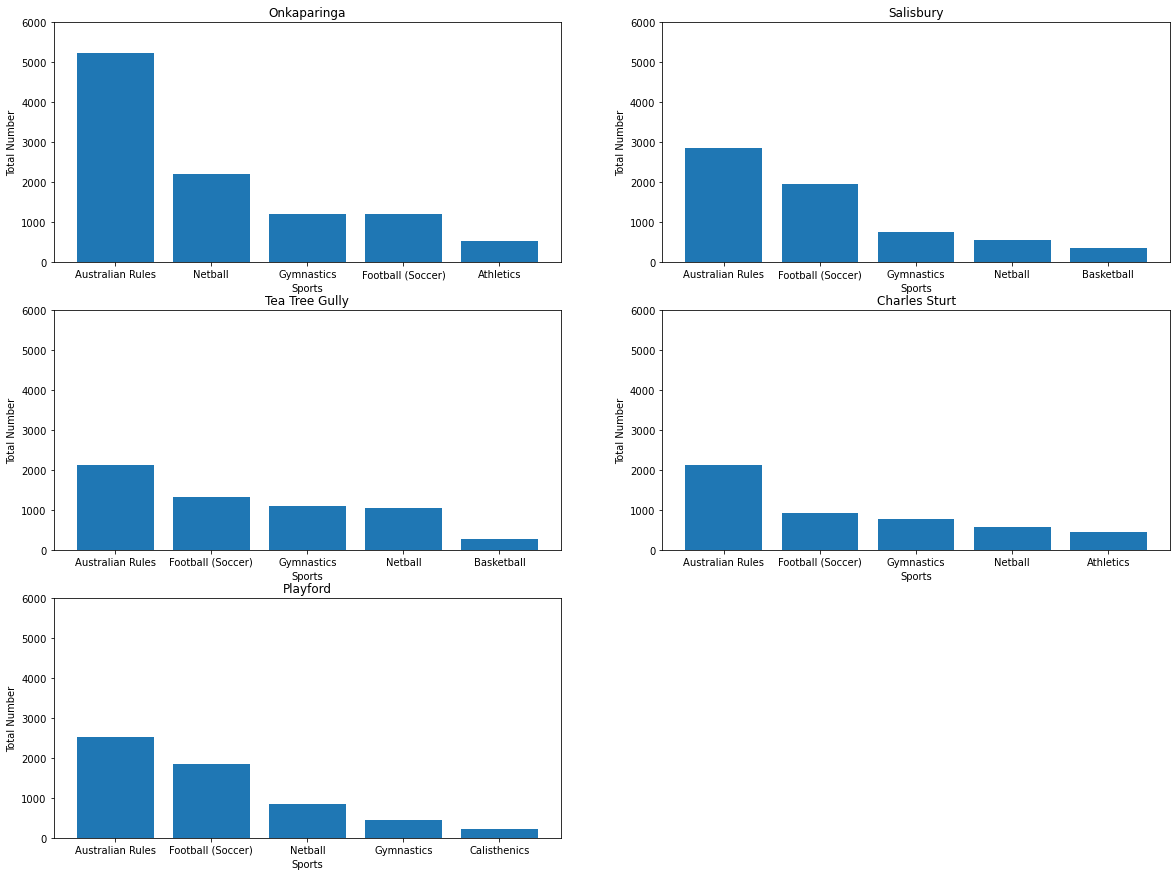

In [97]:
# Plot the first five most popular sports using vouchers in three LGAs
plt.figure(figsize=(20,15))

# Onkaparinga
plt.subplot(3,2,1)
plt.ylim(0,6000)
plt.title("Onkaparinga")
plt.xlabel("Sports")
plt.ylabel("Total Number")
plt.bar(df_first_lga['sports'], df_first_lga['counts'])

# Salisbury
plt.subplot(3,2,2)
plt.ylim(0,6000)
plt.title("Salisbury")
plt.xlabel("Sports")
plt.ylabel("Total Number")
plt.bar(df_second_lga['sports'], df_second_lga['counts'])

# Tea Tree Gully
plt.subplot(3,2,3)
plt.ylim(0,6000)
plt.title("Tea Tree Gully")
plt.xlabel("Sports")
plt.ylabel("Total Number")
plt.bar(df_third_lga['sports'], df_third_lga['counts'])

# Playford
plt.subplot(3,2,4)
plt.ylim(0,6000)
plt.title("Charles Sturt")
plt.xlabel("Sports")
plt.ylabel("Total Number")
plt.bar(df_fourth_lga['sports'], df_fourth_lga['counts'])

# Charles Sturt
plt.subplot(3,2,5)
plt.ylim(0,6000)
plt.title("Playford")
plt.xlabel("Sports")
plt.ylabel("Total Number")
plt.bar(df_fifth_lga['sports'], df_fifth_lga['counts'])

* **_Interpretation about The Summarised Results:_**
Australian Rules is the most standout sport which is undertaken using the sport vouchers in the five LGAs, which is similar to the most standout in all the sports. Football(Soccer) ranks second in Salisbury, Tea Tree Gully, Charles Sturt and Playford. By contrast, Football(Soccer) is the fourth popular sport undertaken by participants who reside in Onkaparinga. Gymnastics ranks third in all the four LGAs except for Playford where it ranks fourth. While Netball is the second popular sport in Onkaparinga, it ranks third in Playford and ranks fourth in Salisbury, Tea Tree Gully and Charles Sturt. The least popular in the five most standout activities in Onkaparinga and Charles Sturt is Athletics, while in both Salisbury and Tea Tree Gully are Basketball, and Calisthenics is the least popular sport in Playford. Onkaparinga reaches the highest score of voucher uses in Australian Rules which is up to around 5300 vouchers used.

### Popularity of Sports across Different Parts of The State

In [98]:
# Dataframe includes the LGA and sports
lga_sport

,Participant_LGA,Voucher_Sport
0,ONKAPARINGA,Australian Rules
1,ONKAPARINGA,Australian Rules
2,ONKAPARINGA,Gymnastics
3,ONKAPARINGA,Gymnastics
4,ONKAPARINGA,Gymnastics
...,...,...
127521,MID MURRAY,Netball
127522,MID MURRAY,Netball
127523,MID MURRAY,Netball
127524,MID MURRAY,Netball


In [99]:
# group the dataset based on LGA and Sport, then count the total participants in each activity
lga_group = lga_sport.groupby([ 'Voucher_Sport', 'Participant_LGA']).size()
lga_group

Voucher_Sport  Participant_LGA
Archery        ADELAIDE HILLS      3
               ALEXANDRINA         9
               BURNSIDE            2
               CHARLES STURT       1
               HOLDFAST BAY        1
                                  ..
Weightlifting  MARION              2
               MITCHAM             2
Wrestling      CHARLES STURT       1
               MARION              3
               ONKAPARINGA        15
Length: 1105, dtype: int64

In [100]:
# turn the "groupby" dataset into a dataframe
lga_group = lga_group.unstack(level=0)
lga_group

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,NaN,16.0,128.0,NaN,NaN,1.0,4.0,NaN,1.0,2.0,...,NaN,NaN,NaN,11.0,4.0,NaN,NaN,NaN,NaN,NaN
ADELAIDE HILLS,3.0,204.0,1358.0,2.0,NaN,11.0,48.0,NaN,62.0,128.0,...,NaN,18.0,3.0,44.0,249.0,2.0,1.0,1.0,NaN,NaN
ALEXANDRINA,9.0,62.0,973.0,4.0,3.0,NaN,180.0,NaN,5.0,8.0,...,2.0,11.0,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN
BAROSSA,NaN,158.0,1191.0,3.0,NaN,6.0,339.0,NaN,9.0,56.0,...,NaN,12.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN
BARUNGA WEST,NaN,1.0,86.0,NaN,NaN,NaN,12.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,895.0,2.0,NaN,12.0,67.0,NaN,44.0,85.0,...,NaN,74.0,4.0,27.0,158.0,1.0,4.0,2.0,NaN,NaN
WHYALLA,NaN,15.0,565.0,NaN,NaN,NaN,605.0,NaN,15.0,10.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WUDINNA,NaN,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# Fill all the NaN value to 0
lga_group.fillna(0)

Voucher_Sport,Archery,Athletics,Australian Rules,BMX,Badminton,Baseball,Basketball,Bowls,Calisthenics,Cricket,...,Surf Riding,Swimming,Table Tennis,Taekwondo,Tennis,Touch,Volleyball,Water Polo,Weightlifting,Wrestling
Participant_LGA,,,,,,,,,,,,,,,,,,,,,
ADELAIDE,0.0,16.0,128.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,...,0.0,0.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0
ADELAIDE HILLS,3.0,204.0,1358.0,2.0,0.0,11.0,48.0,0.0,62.0,128.0,...,0.0,18.0,3.0,44.0,249.0,2.0,1.0,1.0,0.0,0.0
ALEXANDRINA,9.0,62.0,973.0,4.0,3.0,0.0,180.0,0.0,5.0,8.0,...,2.0,11.0,0.0,0.0,109.0,0.0,0.0,0.0,0.0,0.0
BAROSSA,0.0,158.0,1191.0,3.0,0.0,6.0,339.0,0.0,9.0,56.0,...,0.0,12.0,0.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0
BARUNGA WEST,0.0,1.0,86.0,0.0,0.0,0.0,12.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,1.0,114.0,895.0,2.0,0.0,12.0,67.0,0.0,44.0,85.0,...,0.0,74.0,4.0,27.0,158.0,1.0,4.0,2.0,0.0,0.0
WHYALLA,0.0,15.0,565.0,0.0,0.0,0.0,605.0,0.0,15.0,10.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WUDINNA,0.0,29.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* **_Comment:_** 

Since any NaN value in any LGA means there is no record for this LGA with the specific sport, filling with 0 is probably the suitable method in this case -- There is no participant using voucher in those "NaN value" sports in specific regions/LGAs.

* **_Plot Heatmap for all the sports with LGAs:_**

As there are up to 67 different LGAs involved in the dataset, we separately plot three heatmaps for the dataset (two separate plots contain 22 LGAs, one contains 23). Then, we can compare and evaluate the distribution of sport vouchers across all regions easily.

*_Assumption:_*

Assume any sport which is undertaken using over 4000 vouchers is considered as highly popular sport in the corresponding region. Therefore, the maximum of the heatmap colouring level is set to be 4000, which other less popular sports (compared to over 4000-participant sports) could be shown clearer. This then would improve the analysis about the popular sports within the state. 

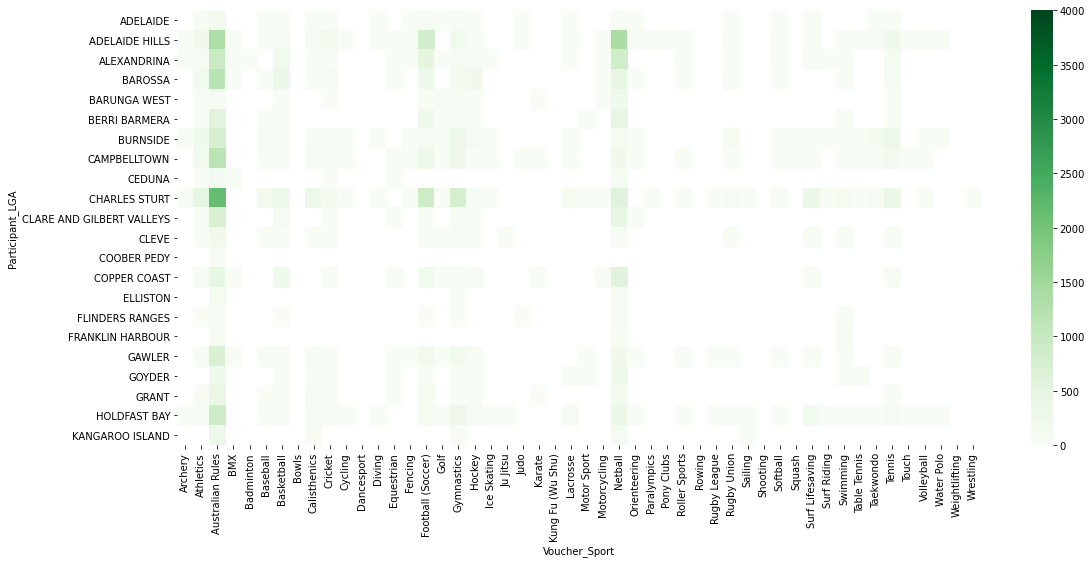

In [102]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(lga_group[:22], cmap="Greens", vmin = 0, vmax= 4000)
plt.show()

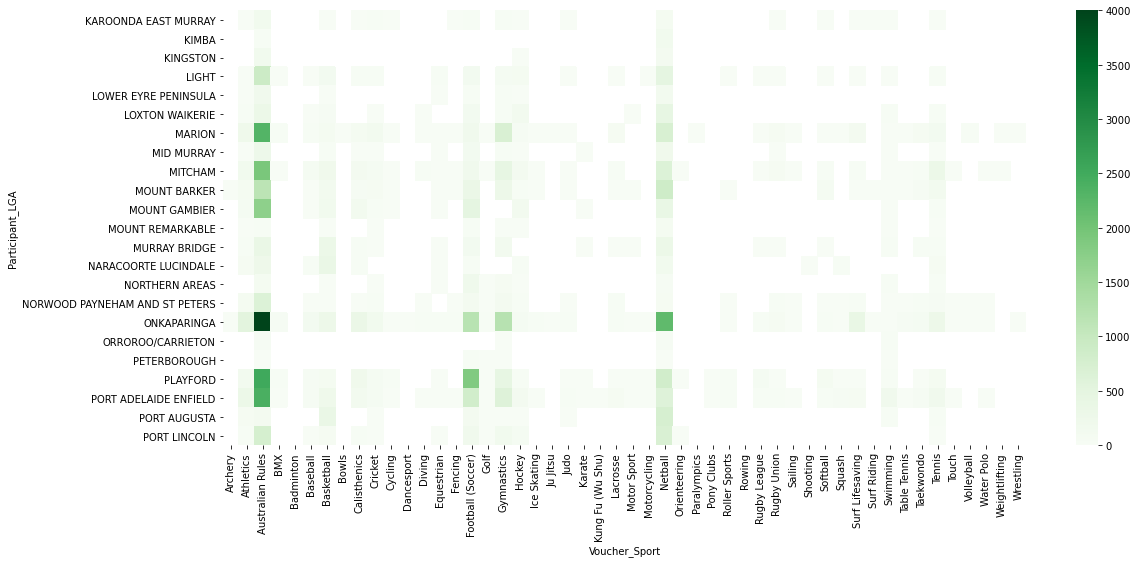

In [103]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(lga_group[22:45], cmap="Greens", vmin = 0, vmax= 4000)
plt.show()

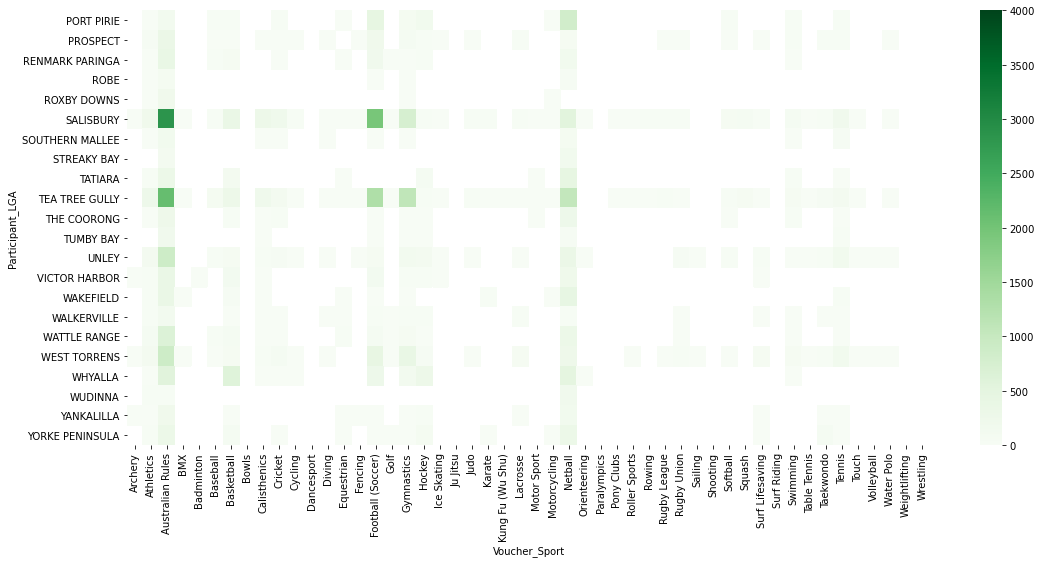

In [104]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(lga_group[45:], cmap="Greens", vmin = 0, vmax= 4000)
plt.show()

* **_Interpretation about the popular sport between LGAs:_**

By observing the heatmap, it is obvious that Australian Rules is possibly the most popular sport across the South Australia, which can be clearly seen in Onkaparinga, Salisbury, Playford, Port Adelaide Enfield, Marion, Charles Sturt, Mitcham, Mount Gambier, Adelaide Hills, Barossa, Alexandrina, Campbelltown, Mount Barker and Tea Tree Gully. The Football (Soccer) is popular in Salisbury, Playford, Tea Tree Gully, Onkaparinga, Charles Sturt, Port Adelaide Enfield and Adelaide Hills. Another sport should be noticed is Netball, which is more popular in Tea Tree Gully, Port Pirie, Port Lincoln, Port Augusta, Port Adelaide Enfield, Playford, Onkaparinga, Mount Baker, Marion, Alexandrina and Adelaide Hills. The Gymnastics is popular in Tea Tree Gully, Salisbury, Port Adelaide Enfield, Playford, Onkaparinga, Marion, and Charles Sturt. Other sports might not be so obvious to observe due to the small number of vouchers used to participate in those sports. However, if we carefully observe the heatmap, we still could find that some sports such as Basketball is popular in Alexandrina, Barossa, Light, Murray Bridge, Naracoorte Lucindale, Salisbury, Tea Tree Gully and Whyalla. Tennis is popular in Salisbury, Onkaparinga, Mitcham, Marion, Charles Sturt, Burnside, and Adelaide Hills. Surf Lifesaving is popular in Onkaparinga.

### LGAs That Are Over or Under Represented Their Uses of Vouchers

* ***Plotting of the distribution of the voucher uses across all the LGAs***

In [105]:
# Create a dataframe containing LGA and the counts of voucher uses
lga_count = sa_vouchers_scores['Participant_LGA'].value_counts().rename_axis('LGA').reset_index(name='counts')
lga_count

,LGA,counts
0,ONKAPARINGA,12673
1,SALISBURY,8032
2,TEA TREE GULLY,7148
3,CHARLES STURT,6832
4,PLAYFORD,6773
...,...,...
62,FRANKLIN HARBOUR,155
63,ORROROO/CARRIETON,137
64,FLINDERS RANGES,102
65,PETERBOROUGH,45


In [106]:
# Summary of the voucher uses of all the LGA
lga_count.describe()

,counts
count,67.000000
mean,1850.149254
std,2345.963311
min,39.000000
25%,328.500000
50%,1013.000000
75%,2207.000000
max,12673.000000


<BarContainer object of 67 artists>

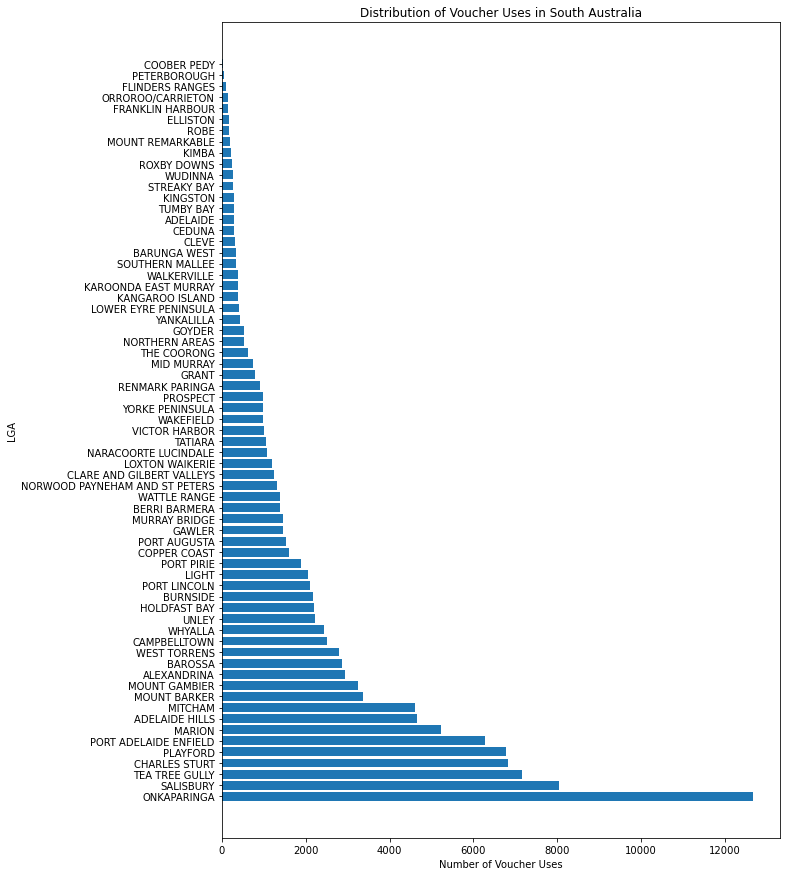

In [107]:
# plot the distribution of voucher uses across the South Australia
plt.figure( figsize = (10,15) )
plt.title("Distribution of Voucher Uses in South Australia")
plt.xlabel("Number of Voucher Uses")
plt.ylabel("LGA")
plt.barh(lga_count['LGA'], lga_count['counts'])

* ***Interpretation:***  By looking at the summary and the plot, Onkaparinga is the LGA which used the most vouchers (12673 voucher uses), while Coober Pedy is the LGA which uses the least vouchers (39 voucher uses). The average use of vouchers is around 1850 uses. Therefore, we assume any LGA which is over 4000 uses as overrepresented in the uses of vouchers, which includes Mitcham, Adelaide Hills, Marion, Port Adelaide Enfield, Playford, Charles Sturt, Tea Tree Gully, Salisbury and Onkaparinga. By contrast, underrepresented uses of vouchers could possibly be assumed in any LGA which has less than 250 uses of vouchers. 

To be clearer about the LGAs which are underrepresented, we extract the table containing LGAs which have less than 250 uses of vouchers from the `lga_count` dataframe.

In [108]:
# LGA that have less than 250 uses of vouchers
lga_count[lga_count.counts <= 250]

,LGA,counts
57,ROXBY DOWNS,234
58,KIMBA,211
59,MOUNT REMARKABLE,203
60,ROBE,167
61,ELLISTON,165
62,FRANKLIN HARBOUR,155
63,ORROROO/CARRIETON,137
64,FLINDERS RANGES,102
65,PETERBOROUGH,45
66,COOBER PEDY,39


Thus, LGAs which are considered as underrepresented their uses of vouchers including Coober Pedy, Peterborough, Flinders Ranges, Orroroo/Carrieton, Franklin Harbour, Elliston, Robe, Mount Remarkable, Kimba and Roxby Downs.

* ***Compare the uses of vouchers over the population***

In [109]:
# joining the voucher uses with population
lga_seifa_vouchers = lga_count.join(LGA_scores, on = "LGA")
lga_seifa_vouchers.head(15)

,LGA,counts,IEO,IER,IRSAD,IRSD,Population
0,ONKAPARINGA,12673,996,996,975,993,159517
1,SALISBURY,8032,960,960,924,937,129067
2,TEA TREE GULLY,7148,1026,1026,1019,1037,95461
3,CHARLES STURT,6832,957,957,971,976,104922
4,PLAYFORD,6773,914,914,868,871,79082
5,PORT ADELAIDE ENFIELD,6280,921,921,929,930,112797
6,MARION,5231,974,974,990,1000,83005
7,ADELAIDE HILLS,4652,1083,1083,1077,1081,38601
8,MITCHAM,4617,1041,1041,1068,1068,62912
9,MOUNT BARKER,3370,1036,1036,1021,1032,29806


In [110]:
# calculate percentage of the voucher uses over the population
lga_seifa_vouchers["Percentage"] = (lga_seifa_vouchers.counts*100)/lga_seifa_vouchers.Population

<ipython-input-111-29c4fee0960e>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis = plt.subplot()


<BarContainer object of 67 artists>

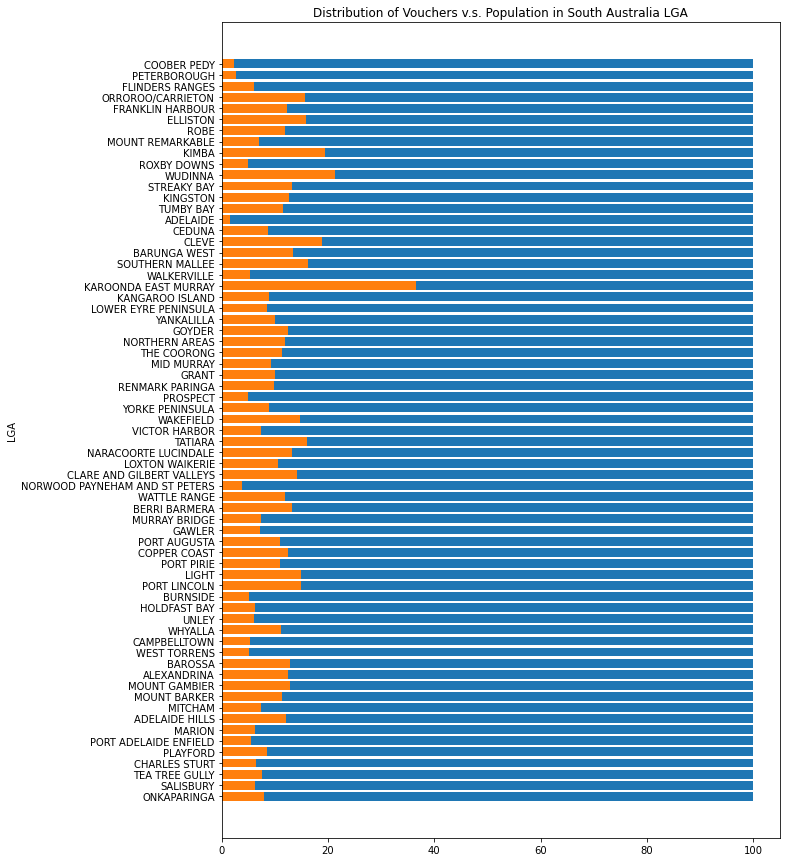

In [111]:
# plotting the pecentage of voucher uses over the population (100)
plt.figure( figsize = (10,15) )
plt.title("Distribution of Vouchers v.s. Population in South Australia LGA")
plt.ylabel("LGA")
axis = plt.subplot()
axis.barh(lga_seifa_vouchers["LGA"], 100)
axis.barh(lga_seifa_vouchers["LGA"], lga_seifa_vouchers["Percentage"])

* ***Interpretation:*** By comparing the uses of vouchers over the polulation (in %), it is obvious that the uses of vouchers in Karoonda East Murray accounts for nearly 40% of the population of this LGA, which is the highest percentage compared to other LGAs. By contrast, Adelaide is the LGA which has the least voucher uses in percentage over its population compared to other LGAs. Thus, by comparing the voucher uses over the population in every LGA, we could observe that Onkaparinga does not rank first in the voucher uses as its population is mch larger compared to the uses of vouchers. Therefore, in this case, the overrepresented voucher uses in LGAs over the population could be seen in Karronda East Murray, Wudinna, Kimba and Cleve. On the other hand, the underepresented LGAs include Adelaide, Coober Pedy, Peterborough, and Norwood Payneham and St Peters.

### Relationship between The Voucher Use and Any SEIFA Measures in an LGA

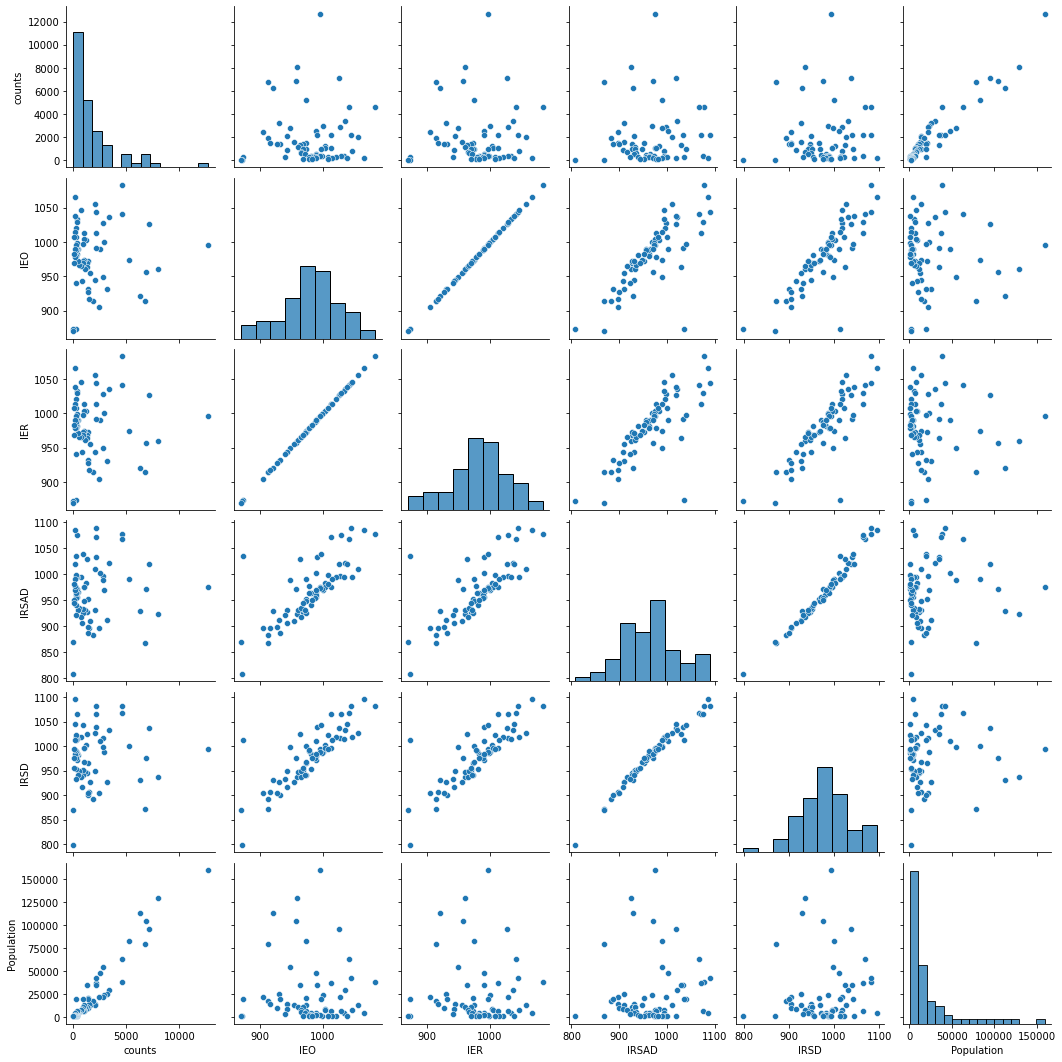

In [112]:
# Plotting to see how each SEIFA measure varies the voucher uses
sns.pairplot(lga_seifa_vouchers[['counts', 'IEO', 'IER', 'IRSAD', 'IRSD', 'Population']])

* ***Interpretation:*** We could see the only feature which might be correlated to the voucher uses is the population.

* ***Correlation Calculation***

In [113]:
IEO_vouchers = np.corrcoef(lga_seifa_vouchers.counts, lga_seifa_vouchers.IEO)
print("The Correlation of IEO and the voucher uses:\n", IEO_vouchers)

IER_vouchers = np.corrcoef(lga_seifa_vouchers.counts, lga_seifa_vouchers.IER)
print("The Correlation of IER and the voucher uses:\n", IER_vouchers)

IRSAD_vouchers = np.corrcoef(lga_seifa_vouchers.counts, lga_seifa_vouchers.IRSAD)
print("The Correlation of IRSAD and the voucher uses:\n", IRSAD_vouchers)

IRSD_vouchers = np.corrcoef(lga_seifa_vouchers.counts, lga_seifa_vouchers.IRSD)
print("The Correlation of IRSD and the voucher uses:\n", IRSD_vouchers)

The Correlation of IEO and the voucher uses:
 [[1.         0.00846501]
 [0.00846501 1.        ]]
The Correlation of IER and the voucher uses:
 [[1.         0.00846501]
 [0.00846501 1.        ]]
The Correlation of IRSAD and the voucher uses:
 [[1.         0.05191691]
 [0.05191691 1.        ]]
The Correlation of IRSD and the voucher uses:
 [[1.         0.03391126]
 [0.03391126 1.        ]]


* ***Comment:*** We can see all the correlation of the SEIFA measures and the voucher uses are not closed to 1 or -1. Therefore, there is significantly weak relationship between any SEIFA measure and the voucher uses.

In [114]:
pop_vouchers = np.corrcoef(lga_seifa_vouchers.counts, lga_seifa_vouchers.Population)
print("The Correlation of population and the voucher uses:\n", pop_vouchers)

The Correlation of population and the voucher uses:
 [[1.         0.95998675]
 [0.95998675 1.        ]]


* ***Comment:*** By contrast, there is a strong relationship between the population and the uses of vouchers.

* ***Uses of vouchers in low, middle, and high socio-economic area***

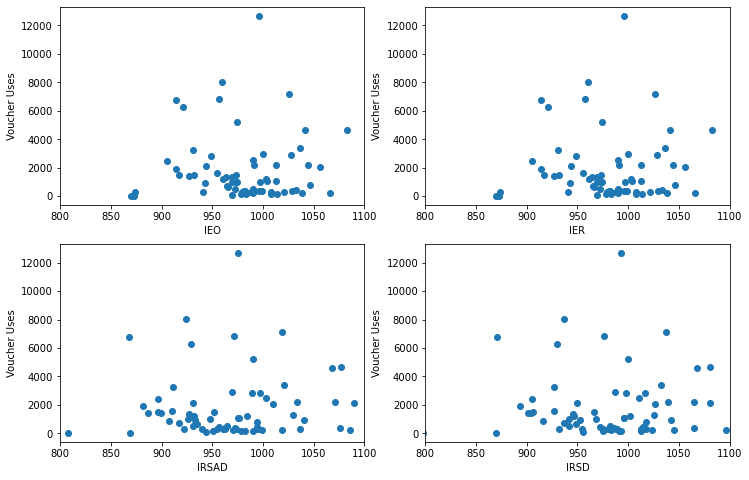

In [115]:
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.xlim(800,1100)
plt.xlabel("IEO")
plt.ylabel("Voucher Uses")
plt.scatter(lga_seifa_vouchers['IEO'], lga_seifa_vouchers['counts'])

plt.subplot(2,2,2)
plt.xlim(800, 1100)
plt.xlabel("IER")
plt.ylabel("Voucher Uses")
plt.scatter(lga_seifa_vouchers['IER'], lga_seifa_vouchers['counts'])

plt.subplot(2,2,3)
plt.xlim(800, 1100)
plt.xlabel("IRSAD")
plt.ylabel("Voucher Uses")
plt.scatter(lga_seifa_vouchers['IRSAD'], lga_seifa_vouchers['counts'])

plt.subplot(2,2,4)
plt.xlim(800,1100)
plt.xlabel("IRSD")
plt.ylabel("Voucher Uses")
plt.scatter(lga_seifa_vouchers['IRSD'], lga_seifa_vouchers['counts'])

* ***Interpretation:*** Although there is no strong relationship between SEIFA measures and the voucher uses, we could see that there are more vouchers (areas with large number of voucher uses) being used in those LGAs with middle-high scores of the socio-economic disadvantage, and the socio-economic advantage and disadvantage which indicates lack of disadvantage and greater advantage in general. This could be seen similarly in the scores of education and occupation, and the economic resource, which the middle-high socio-economic areas use more vouchers to participant in sport than in low score areas. Thus, the uses of vouchers is probably not distributed equally in all the areas although there are only a few LGA ranked in low score areas.

* ***Relationship of the voucher uses and population in LGA***

In [116]:
# import linear regression function
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

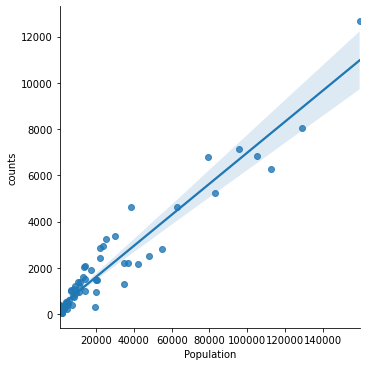

In [117]:
# Plotting the relationship of this two variables
sns.lmplot(x='Population', y='counts', data= lga_seifa_vouchers)

In [118]:
# split into train and test
train, test= train_test_split(lga_seifa_vouchers, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(53, 8)
(14, 8)


In [119]:
X_train = train[['Population']]
y_train = train['counts']

X_test = test[[ 'Population']]
y_test = test['counts']

In [120]:
# fitting model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [121]:
# linear formula
print("y = X*", reg.coef_, "+", reg.intercept_)

y = X* [0.06754296] + 272.9446042900979


In [122]:
test_preds = reg.predict(X_test)

In [123]:
mse_vouchers = mean_squared_error(y_test, test_preds)
print("Test MSE:", mse_vouchers)
print("Test Root MSE:", np.sqrt(mse_vouchers))
print("Test R squared:",r2_score(y_test, test_preds))

Test MSE: 566318.4896409368
Test Root MSE: 752.541354106827
Test R squared: 0.8456406206084108


* ***Comment:*** The model built on the correlation of population and the voucher uses in LGA with $R^2$ of around 0.85, and the MSE corresponds to the prediction error of 753 uses. By looking at the regression plot and the linear formula above, we could see that the use of vouchers increases gradually by the population, which means in LGAs where there are large population, it is more common for parents to use voucher for their kids to participate in any provided sports. Thus, when the population is getting large (areas with large population), the voucher uses will also be higher than small population LGAs.

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [126]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


### Data Manipulation

We repeat the same steps as working with the South Australia dataset where a new SEIFA dataset only includes the LGA from Queensland (start with '3' in the LGA number, which avoids duplication of the LGA names in different states.

In [129]:
qld_seifa = seifa[seifa['LGA_2011'].astype(str).str[0] == '3']
qld_seifa

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
932,30250,Aurukun (S),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,586,AURUKUN
933,30250,Aurukun (S),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,586,AURUKUN
934,30250,Aurukun (S),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,586,AURUKUN
935,30250,Aurukun (S),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,1292,AURUKUN
936,30300,Balonne (S),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,950,BALONNE
...,...,...,...,...,...,...,...,...
7991,37570,Wujal Wujal (S),IEO,Index of Education and Occupation,URP,Usual resident population,269,WUJAL WUJAL
7992,37600,Yarrabah (S),IEO,Index of Education and Occupation,SCORE,Score,472,YARRABAH
7993,37600,Yarrabah (S),IEO,Index of Education and Occupation,MINS,Minimum score for SA1s in area,469,YARRABAH
7994,37600,Yarrabah (S),IEO,Index of Education and Occupation,MAXS,Maximum score for SA1s in area,475,YARRABAH


In [131]:
# check if still having duplicated LGA
temp = qld_seifa['LGA'].value_counts().rename_axis('LGA').reset_index(name='counts')
temp.head()

temp[temp.counts > 16]

,LGA,counts


* ***Comment:*** There is no more duplicated LGA in the dataset.

In [132]:
# update the pivot table
LGA_scores = qld_seifa[qld_seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = qld_seifa[qld_seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_pop.head()
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
AURUKUN,521,521,586,483,1292
BALONNE,973,973,950,959,4719
BANANA,1017,1017,980,997,14451
BARCALDINE,998,998,974,992,3217
BARCOO,989,989,947,953,352


In [141]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RCS]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

<ipython-input-141-d1d112fcd857>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RCS]+\)', '').str.upper()


,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0


We continue checking if there is missing value in the joined dataset.

In [142]:
# check the size of the dataset
qld_vouchers_scores.shape

(9507, 18)

In [143]:
qld_vouchers_scores.isna().sum()

Application Number                        0
Voucher Number                            0
Child Age (at time of Application)        0
Gender                                 9507
Has your child played sport before?       4
Participation Activity                    0
Club Name                                 0
Club Suburb/Town                          0
Club Local Government Area Name           0
Club State Electoral District  Name       0
Parent Suburb/Town                        0
Total Payment                             0
LGA                                       0
IEO                                     379
IER                                     379
IRSAD                                   379
IRSD                                    379
Population                              379
dtype: int64

* ***Comment:*** There is no gender records in every row in the dataset. Therefore, we will drop the gender column off the dataset.

In [144]:
qld_vouchers_scores.drop(['Gender'], axis=1, inplace= True)

In [145]:
# Check the LGAs which have no population records 
# (the same with IEO, IER, IRSAD, IRSD which come from the SEIFA dataset)
qld_vouchers_scores['LGA'][qld_vouchers_scores.Population.isna()].value_counts()

NOOSA          274
MAREEBA         62
DOUGLAS         33
LIVINGSTONE      7
HERVEY BAY       3
Name: LGA, dtype: int64

* ***Comment:*** There are some LGA with missing value. We check if the LGA_scores has missing value or not, then we check if the name of LGA is the same in two datasets.

In [146]:
# check if there is NaN value in the LGA_scores (i.e. SEIFA pivot dataset)
LGA_scores.isna().sum()

INDEX_TYPE
IEO           0
IER           0
IRSAD         0
IRSD          0
Population    0
dtype: int64

In [161]:
# Check if there is any LGA in the LGA_scores dataset is the same as the LGA holding NaN value
LGA_scores[(LGA_scores.index.str[:3] == "NOO") |
           (LGA_scores.index.str[:5] == "MAREE") |
           (LGA_scores.index.str[:3] == "DOU") |
           (LGA_scores.index.str[:6] == "LIVING") |
           (LGA_scores.index.str[:6] == "HERVEY")]

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,


* ***Comment:*** There is no LGA which having missing value in the qld_vouchers that maps the LGA_scores dataset. Therefore, we drop these data rows since we cannot analyse the relationship of these variables if they are missing. We also drop the four missing values in the "Has your child played sport before?" column, since there are only four rows of records over around 9000 records and they are missing values. Thus, they might not be accurate records.

In [163]:
qld_vouchers_scores = qld_vouchers_scores.dropna()

### Description of The Distribution of The Vouchers (Compare with The SA Dataset)

In [164]:
# Check the size of the dataset
qld_vouchers_scores.shape

(9124, 17)

In [165]:
# summary of the dataset 
qld_vouchers_scores[["Child Age (at time of Application)", "Total Payment", "IEO", "IER", "IRSAD", "IRSD", "Population"]].describe()

,Child Age (at time of Application),Total Payment,IEO,IER,IRSAD,IRSD,Population
count,9124.000000,9124.000000,9124.000000,9124.000000,9124.000000,9124.000000,9.124000e+03
mean,10.067405,144.100706,1003.801293,1003.801293,996.472490,999.675581,3.920171e+05
std,3.054612,17.180529,22.334995,22.334995,40.267461,34.397349,3.140912e+05
min,5.000000,5.000000,947.000000,947.000000,908.000000,917.000000,9.690000e+02
25%,8.000000,150.000000,1001.000000,1001.000000,965.000000,971.000000,1.561760e+05
50%,10.000000,150.000000,1008.000000,1008.000000,1001.000000,1007.000000,3.068890e+05
75%,12.000000,150.000000,1018.000000,1018.000000,1016.000000,1014.000000,4.945910e+05
max,17.000000,150.200000,1049.000000,1049.000000,1057.000000,1048.000000,1.042074e+06
